**Oversight joint probability * rewards (0.5)**

/tmp/ipython-input-2965961182.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.97])


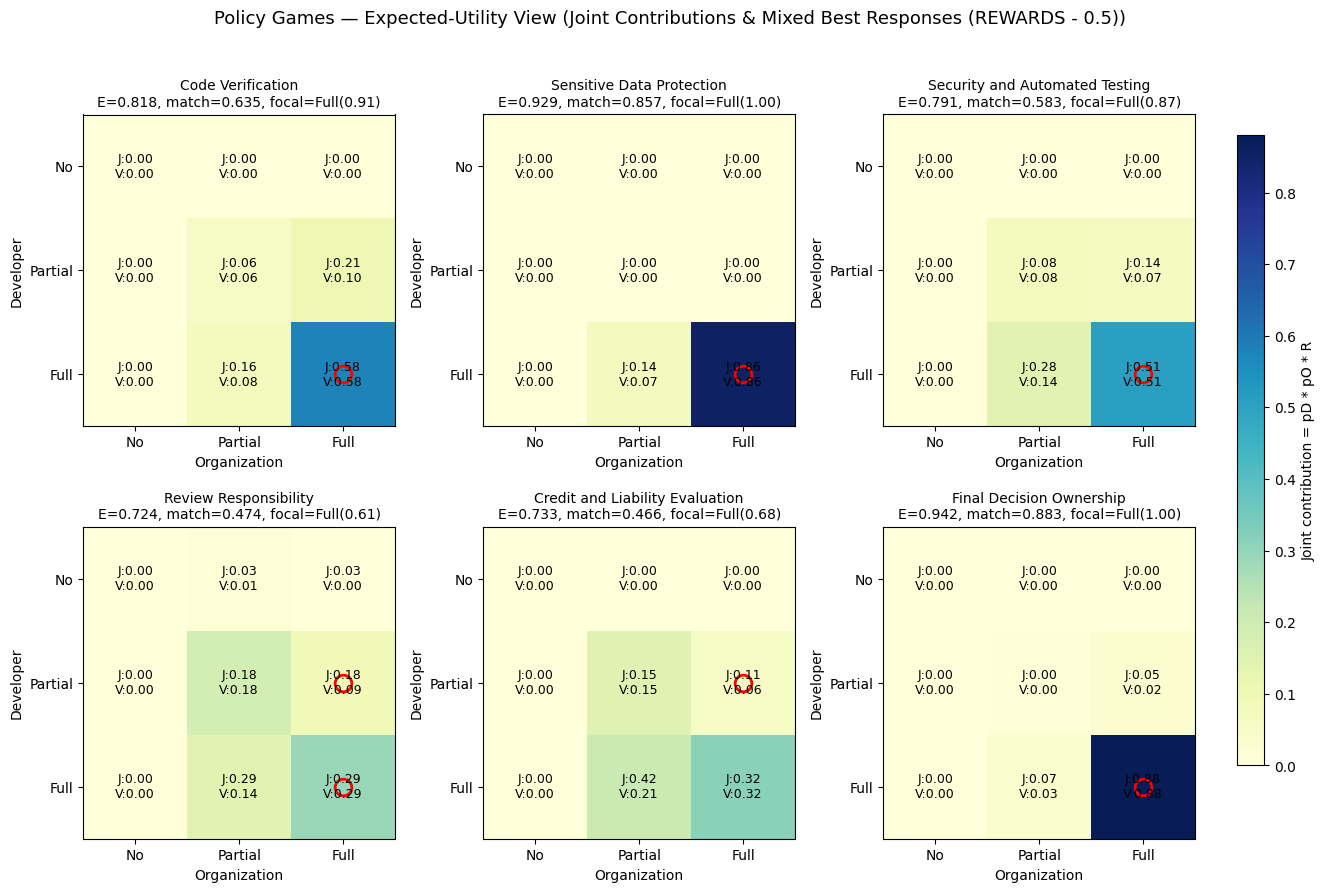


SUMMARY (expected-utility):
- Code Verification: E=0.818 | match=0.635 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.91)
- Sensitive Data Protection: E=0.929 | match=0.857 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=1.00)
- Security and Automated Testing: E=0.791 | match=0.583 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.87)
- Review Responsibility: E=0.724 | match=0.474 | Dev BR rows=['Partial', 'Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.61)
- Credit and Liability Evaluation: E=0.733 | match=0.466 | Dev BR rows=['Partial'] | Org BR cols=['Full'] | Focal diag=Full (share=0.68)
- Final Decision Ownership: E=0.942 | match=0.883 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=1.00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# ---------- data ----------
topics = [
    "Code Verification",
    "Sensitive Data Protection",
    "Security and Automated Testing",
    "Review Responsibility",
    "Credit and Liability Evaluation",
    "Final Decision Ownership",
]

developer_counts = {
    "Code Verification":              {"No": 0, "Partial": 5, "Full": 14},
    "Sensitive Data Protection":      {"No": 0, "Partial": 0, "Full": 19},
    "Security and Automated Testing": {"No": 0, "Partial": 4, "Full": 15},
    "Review Responsibility":          {"No": 1, "Partial": 7, "Full": 11},
    "Credit and Liability Evaluation":{"No": 0, "Partial": 5, "Full": 14},
    "Final Decision Ownership":       {"No": 0, "Partial": 1, "Full": 18},
}

organization_counts = {
    "Code Verification":              {"No": 0, "Partial": 3, "Full": 11},
    "Sensitive Data Protection":      {"No": 0, "Partial": 2, "Full": 12},
    "Security and Automated Testing": {"No": 0, "Partial": 5, "Full": 9},
    "Review Responsibility":          {"No": 0, "Partial": 7, "Full": 7},
    "Credit and Liability Evaluation":{"No": 0, "Partial": 8, "Full": 6},
    "Final Decision Ownership":       {"No": 0, "Partial": 1, "Full": 13},
}

order = ["No", "Partial", "Full"]

def probs(counts_dict, order):
    v = np.array([counts_dict[k] for k in order], dtype=float)
    s = v.sum()
    return (v / s) if s > 0 else np.zeros_like(v)

# reward matrix (graded coordination)
R = np.array([
    [1.0, 0.5, 0.0],
    [0.5, 1.0, 0.5],
    [0.0, 0.5, 1.0],
])

def expected_variant(pD, pO, R, tol=1e-12):
    """
    Expected-utility view:
      - Joint probabilities J = pD ⊗ pO
      - Cell contribution matrix Val = J * R (elementwise)
      - Topic expected payoff E = Val.sum()  (same for both players here since they share R)
      - Developer best rows under mixed pO: argmax_i sum_j R[i,j] pO[j]
      - Org best cols under mixed pD:       argmax_j sum_i pD[i] R[i,j]
    """
    # Joint probabilities for each cell
    J = np.outer(pD, pO)                     # shape (3,3)

    # Per-cell contribution to expected payoff
    Val = J * R                               # elementwise

    # Scalar expected payoff (same for both players with common R)
    E = Val.sum()

    # Best responses under mixed play
    dev_row_exp = R @ pO                      # length-3: expected payoff for each Developer row
    org_col_exp = pD @ R                      # length-3: expected payoff for each Org column

    dev_best_rows = np.where(dev_row_exp >= dev_row_exp.max() - tol)[0]
    org_best_cols = np.where(org_col_exp >= org_col_exp.max() - tol)[0]

    # Helpful diagnostics
    match_prob = np.trace(J)                  # sum of diagonal joint probabilities
    diag_contribs = np.diag(Val)              # contribution of each diagonal cell to E
    focal_diag_idx = int(np.argmax(np.diag(J))) if match_prob > 0 else None
    focal_name = order[focal_diag_idx] if focal_diag_idx is not None else None
    focal_share = (J[focal_diag_idx, focal_diag_idx] / match_prob) if match_prob > 0 else np.nan

    return {
        "J": J,
        "Val": Val,
        "E": E,
        "dev_row_exp": dev_row_exp,
        "org_col_exp": org_col_exp,
        "dev_best_rows": dev_best_rows,
        "org_best_cols": org_best_cols,
        "match_prob": match_prob,
        "diag_contribs": diag_contribs,
        "focal_diag_idx": focal_diag_idx,
        "focal_name": focal_name,
        "focal_share": focal_share,
    }

# ---------- compute ----------
results = []
glob_max = 0.0
for t in topics:
    pD = probs(developer_counts[t], order)
    pO = probs(organization_counts[t], order)
    out = expected_variant(pD, pO, R)
    results.append((t, pD, pO, out))
    glob_max = max(glob_max, out["Val"].max())

# ---------- visualize ----------
n = len(results)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 4.5*nrows))
axes = np.atleast_2d(axes)

last_im = None
for idx, (topic, pD, pO, out) in enumerate(results):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]

    Val = out["Val"]
    J   = out["J"]

    # Heatmap shows per-cell joint contribution to expected payoff
    last_im = ax.imshow(Val, vmin=0.0, vmax=glob_max, cmap="YlGnBu")

    # annotate each cell with joint prob and contrib
    for i in range(3):
        for j in range(3):
            ax.text(j, i,
                    f"J:{J[i,j]:.2f}\nV:{Val[i,j]:.2f}",
                    ha="center", va="center", fontsize=9)

    # mark mutual best responses under mixed play
    for i in out["dev_best_rows"]:
        for j in out["org_best_cols"]:
            ax.plot(j, i, marker='o', markersize=12,
                    markerfacecolor='none', markeredgecolor='red', markeredgewidth=2)

    ax.set_xticks(range(3)); ax.set_yticks(range(3))
    ax.set_xticklabels(order, fontsize=10)
    ax.set_yticklabels(order, fontsize=10)
    ax.set_xlabel("Organization", fontsize=10)
    ax.set_ylabel("Developer", fontsize=10)
    ax.set_title(f"{topic}\nE={out['E']:.3f}, match={out['match_prob']:.3f}, focal={out['focal_name']}({out['focal_share']:.2f})",
                 fontsize=10)

# remove empty axes
for k in range(n, nrows*ncols):
    r, c = divmod(k, ncols)
    fig.delaxes(axes[r, c])

# colorbar outside
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(last_im, cax=cbar_ax, label="Joint contribution = pD * pO * R")

fig.suptitle("Policy Games — Expected-Utility View (Joint Contributions & Mixed Best Responses (REWARDS - 0.5))", fontsize=13, y=0.99)
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()

# ---------- textual summary ----------
print("\nSUMMARY (expected-utility):")
for topic, pD, pO, out in results:
    dev_best = [order[i] for i in out["dev_best_rows"]]
    org_best = [order[j] for j in out["org_best_cols"]]
    print(f"- {topic}: E={out['E']:.3f} | match={out['match_prob']:.3f} | "
          f"Dev BR rows={dev_best} | Org BR cols={org_best} | "
          f"Focal diag={out['focal_name']} (share={out['focal_share']:.2f})")


**Oversight joint probability * rewards (0.4 )**

/tmp/ipython-input-3787077702.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.97])


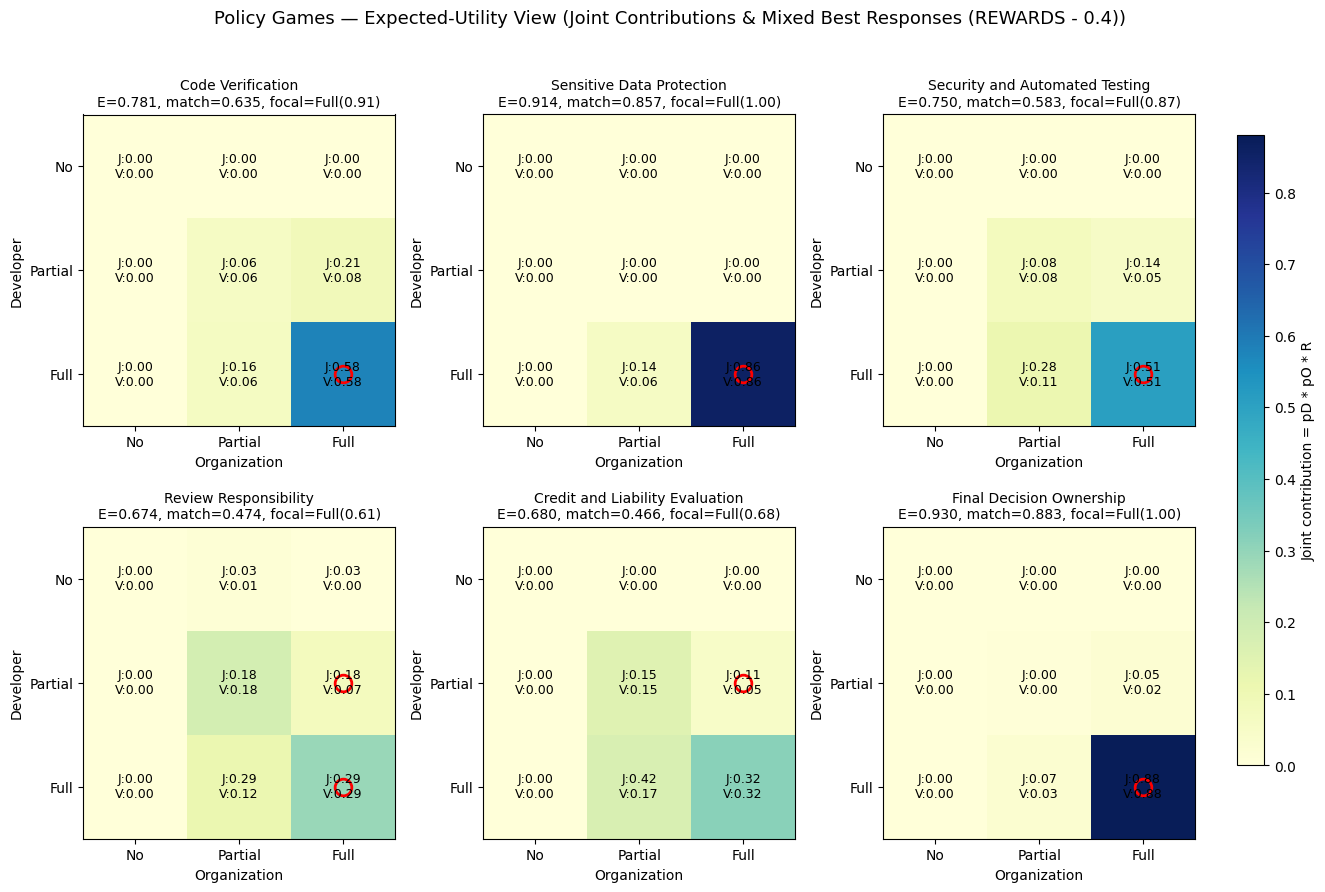


SUMMARY (expected-utility):
- Code Verification: E=0.781 | match=0.635 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.91)
- Sensitive Data Protection: E=0.914 | match=0.857 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=1.00)
- Security and Automated Testing: E=0.750 | match=0.583 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.87)
- Review Responsibility: E=0.674 | match=0.474 | Dev BR rows=['Partial', 'Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.61)
- Credit and Liability Evaluation: E=0.680 | match=0.466 | Dev BR rows=['Partial'] | Org BR cols=['Full'] | Focal diag=Full (share=0.68)
- Final Decision Ownership: E=0.930 | match=0.883 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=1.00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# ---------- data ----------
topics = [
    "Code Verification",
    "Sensitive Data Protection",
    "Security and Automated Testing",
    "Review Responsibility",
    "Credit and Liability Evaluation",
    "Final Decision Ownership",
]

developer_counts = {
    "Code Verification":              {"No": 0, "Partial": 5, "Full": 14},
    "Sensitive Data Protection":      {"No": 0, "Partial": 0, "Full": 19},
    "Security and Automated Testing": {"No": 0, "Partial": 4, "Full": 15},
    "Review Responsibility":          {"No": 1, "Partial": 7, "Full": 11},
    "Credit and Liability Evaluation":{"No": 0, "Partial": 5, "Full": 14},
    "Final Decision Ownership":       {"No": 0, "Partial": 1, "Full": 18},
}

organization_counts = {
    "Code Verification":              {"No": 0, "Partial": 3, "Full": 11},
    "Sensitive Data Protection":      {"No": 0, "Partial": 2, "Full": 12},
    "Security and Automated Testing": {"No": 0, "Partial": 5, "Full": 9},
    "Review Responsibility":          {"No": 0, "Partial": 7, "Full": 7},
    "Credit and Liability Evaluation":{"No": 0, "Partial": 8, "Full": 6},
    "Final Decision Ownership":       {"No": 0, "Partial": 1, "Full": 13},
}

order = ["No", "Partial", "Full"]

def probs(counts_dict, order):
    v = np.array([counts_dict[k] for k in order], dtype=float)
    s = v.sum()
    return (v / s) if s > 0 else np.zeros_like(v)

# reward matrix (graded coordination)
R = np.array([
    [1.0, 0.4, 0.0],
    [0.4, 1.0, 0.4],
    [0.0, 0.4, 1.0],
])

def expected_variant(pD, pO, R, tol=1e-12):
    """
    Expected-utility view:
      - Joint probabilities J = pD ⊗ pO
      - Cell contribution matrix Val = J * R (elementwise)
      - Topic expected payoff E = Val.sum()  (same for both players here since they share R)
      - Developer best rows under mixed pO: argmax_i sum_j R[i,j] pO[j]
      - Org best cols under mixed pD:       argmax_j sum_i pD[i] R[i,j]
    """
    # Joint probabilities for each cell
    J = np.outer(pD, pO)                     # shape (3,3)

    # Per-cell contribution to expected payoff
    Val = J * R                               # elementwise

    # Scalar expected payoff (same for both players with common R)
    E = Val.sum()

    # Best responses under mixed play
    dev_row_exp = R @ pO                      # length-3: expected payoff for each Developer row
    org_col_exp = pD @ R                      # length-3: expected payoff for each Org column

    dev_best_rows = np.where(dev_row_exp >= dev_row_exp.max() - tol)[0]
    org_best_cols = np.where(org_col_exp >= org_col_exp.max() - tol)[0]

    # Helpful diagnostics
    match_prob = np.trace(J)                  # sum of diagonal joint probabilities
    diag_contribs = np.diag(Val)              # contribution of each diagonal cell to E
    focal_diag_idx = int(np.argmax(np.diag(J))) if match_prob > 0 else None
    focal_name = order[focal_diag_idx] if focal_diag_idx is not None else None
    focal_share = (J[focal_diag_idx, focal_diag_idx] / match_prob) if match_prob > 0 else np.nan

    return {
        "J": J,
        "Val": Val,
        "E": E,
        "dev_row_exp": dev_row_exp,
        "org_col_exp": org_col_exp,
        "dev_best_rows": dev_best_rows,
        "org_best_cols": org_best_cols,
        "match_prob": match_prob,
        "diag_contribs": diag_contribs,
        "focal_diag_idx": focal_diag_idx,
        "focal_name": focal_name,
        "focal_share": focal_share,
    }

# ---------- compute ----------
results = []
glob_max = 0.0
for t in topics:
    pD = probs(developer_counts[t], order)
    pO = probs(organization_counts[t], order)
    out = expected_variant(pD, pO, R)
    results.append((t, pD, pO, out))
    glob_max = max(glob_max, out["Val"].max())

# ---------- visualize ----------
n = len(results)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 4.5*nrows))
axes = np.atleast_2d(axes)

last_im = None
for idx, (topic, pD, pO, out) in enumerate(results):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]

    Val = out["Val"]
    J   = out["J"]

    # Heatmap shows per-cell joint contribution to expected payoff
    last_im = ax.imshow(Val, vmin=0.0, vmax=glob_max, cmap="YlGnBu")

    # annotate each cell with joint prob and contrib
    for i in range(3):
        for j in range(3):
            ax.text(j, i,
                    f"J:{J[i,j]:.2f}\nV:{Val[i,j]:.2f}",
                    ha="center", va="center", fontsize=9)

    # mark mutual best responses under mixed play
    for i in out["dev_best_rows"]:
        for j in out["org_best_cols"]:
            ax.plot(j, i, marker='o', markersize=12,
                    markerfacecolor='none', markeredgecolor='red', markeredgewidth=2)

    ax.set_xticks(range(3)); ax.set_yticks(range(3))
    ax.set_xticklabels(order, fontsize=10)
    ax.set_yticklabels(order, fontsize=10)
    ax.set_xlabel("Organization", fontsize=10)
    ax.set_ylabel("Developer", fontsize=10)
    ax.set_title(f"{topic}\nE={out['E']:.3f}, match={out['match_prob']:.3f}, focal={out['focal_name']}({out['focal_share']:.2f})",
                 fontsize=10)

# remove empty axes
for k in range(n, nrows*ncols):
    r, c = divmod(k, ncols)
    fig.delaxes(axes[r, c])

# colorbar outside
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(last_im, cax=cbar_ax, label="Joint contribution = pD * pO * R")

fig.suptitle("Policy Games — Expected-Utility View (Joint Contributions & Mixed Best Responses (REWARDS - 0.4))", fontsize=13, y=0.99)
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()

# ---------- textual summary ----------
print("\nSUMMARY (expected-utility):")
for topic, pD, pO, out in results:
    dev_best = [order[i] for i in out["dev_best_rows"]]
    org_best = [order[j] for j in out["org_best_cols"]]
    print(f"- {topic}: E={out['E']:.3f} | match={out['match_prob']:.3f} | "
          f"Dev BR rows={dev_best} | Org BR cols={org_best} | "
          f"Focal diag={out['focal_name']} (share={out['focal_share']:.2f})")


**Oversight joint probability * rewards (0.6)**

/tmp/ipython-input-336877274.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.97])


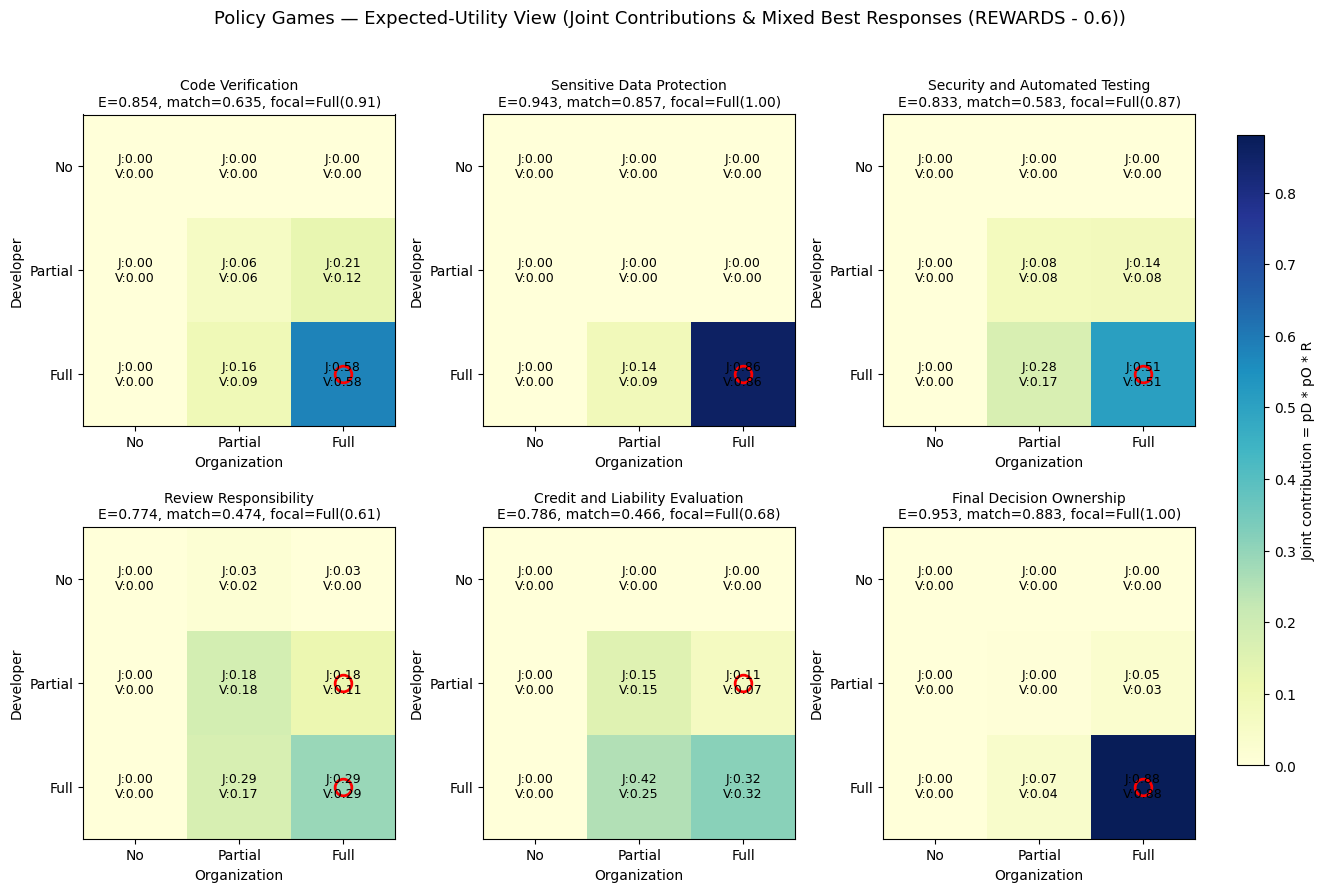


SUMMARY (expected-utility):
- Code Verification: E=0.854 | match=0.635 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.91)
- Sensitive Data Protection: E=0.943 | match=0.857 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=1.00)
- Security and Automated Testing: E=0.833 | match=0.583 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.87)
- Review Responsibility: E=0.774 | match=0.474 | Dev BR rows=['Partial', 'Full'] | Org BR cols=['Full'] | Focal diag=Full (share=0.61)
- Credit and Liability Evaluation: E=0.786 | match=0.466 | Dev BR rows=['Partial'] | Org BR cols=['Full'] | Focal diag=Full (share=0.68)
- Final Decision Ownership: E=0.953 | match=0.883 | Dev BR rows=['Full'] | Org BR cols=['Full'] | Focal diag=Full (share=1.00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# ---------- data ----------
topics = [
    "Code Verification",
    "Sensitive Data Protection",
    "Security and Automated Testing",
    "Review Responsibility",
    "Credit and Liability Evaluation",
    "Final Decision Ownership",
]

developer_counts = {
    "Code Verification":              {"No": 0, "Partial": 5, "Full": 14},
    "Sensitive Data Protection":      {"No": 0, "Partial": 0, "Full": 19},
    "Security and Automated Testing": {"No": 0, "Partial": 4, "Full": 15},
    "Review Responsibility":          {"No": 1, "Partial": 7, "Full": 11},
    "Credit and Liability Evaluation":{"No": 0, "Partial": 5, "Full": 14},
    "Final Decision Ownership":       {"No": 0, "Partial": 1, "Full": 18},
}

organization_counts = {
    "Code Verification":              {"No": 0, "Partial": 3, "Full": 11},
    "Sensitive Data Protection":      {"No": 0, "Partial": 2, "Full": 12},
    "Security and Automated Testing": {"No": 0, "Partial": 5, "Full": 9},
    "Review Responsibility":          {"No": 0, "Partial": 7, "Full": 7},
    "Credit and Liability Evaluation":{"No": 0, "Partial": 8, "Full": 6},
    "Final Decision Ownership":       {"No": 0, "Partial": 1, "Full": 13},
}

order = ["No", "Partial", "Full"]

def probs(counts_dict, order):
    v = np.array([counts_dict[k] for k in order], dtype=float)
    s = v.sum()
    return (v / s) if s > 0 else np.zeros_like(v)

# reward matrix (graded coordination)
R = np.array([
    [1.0, 0.6, 0.0],
    [0.6, 1.0, 0.6],
    [0.0, 0.6, 1.0],
])

def expected_variant(pD, pO, R, tol=1e-12):
    """
    Expected-utility view:
      - Joint probabilities J = pD ⊗ pO
      - Cell contribution matrix Val = J * R (elementwise)
      - Topic expected payoff E = Val.sum()  (same for both players here since they share R)
      - Developer best rows under mixed pO: argmax_i sum_j R[i,j] pO[j]
      - Org best cols under mixed pD:       argmax_j sum_i pD[i] R[i,j]
    """
    # Joint probabilities for each cell
    J = np.outer(pD, pO)                     # shape (3,3)

    # Per-cell contribution to expected payoff
    Val = J * R                               # elementwise

    # Scalar expected payoff (same for both players with common R)
    E = Val.sum()

    # Best responses under mixed play
    dev_row_exp = R @ pO                      # length-3: expected payoff for each Developer row
    org_col_exp = pD @ R                      # length-3: expected payoff for each Org column

    dev_best_rows = np.where(dev_row_exp >= dev_row_exp.max() - tol)[0]
    org_best_cols = np.where(org_col_exp >= org_col_exp.max() - tol)[0]

    # Helpful diagnostics
    match_prob = np.trace(J)                  # sum of diagonal joint probabilities
    diag_contribs = np.diag(Val)              # contribution of each diagonal cell to E
    focal_diag_idx = int(np.argmax(np.diag(J))) if match_prob > 0 else None
    focal_name = order[focal_diag_idx] if focal_diag_idx is not None else None
    focal_share = (J[focal_diag_idx, focal_diag_idx] / match_prob) if match_prob > 0 else np.nan

    return {
        "J": J,
        "Val": Val,
        "E": E,
        "dev_row_exp": dev_row_exp,
        "org_col_exp": org_col_exp,
        "dev_best_rows": dev_best_rows,
        "org_best_cols": org_best_cols,
        "match_prob": match_prob,
        "diag_contribs": diag_contribs,
        "focal_diag_idx": focal_diag_idx,
        "focal_name": focal_name,
        "focal_share": focal_share,
    }

# ---------- compute ----------
results = []
glob_max = 0.0
for t in topics:
    pD = probs(developer_counts[t], order)
    pO = probs(organization_counts[t], order)
    out = expected_variant(pD, pO, R)
    results.append((t, pD, pO, out))
    glob_max = max(glob_max, out["Val"].max())

# ---------- visualize ----------
n = len(results)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 4.5*nrows))
axes = np.atleast_2d(axes)

last_im = None
for idx, (topic, pD, pO, out) in enumerate(results):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]

    Val = out["Val"]
    J   = out["J"]

    # Heatmap shows per-cell joint contribution to expected payoff
    last_im = ax.imshow(Val, vmin=0.0, vmax=glob_max, cmap="YlGnBu")

    # annotate each cell with joint prob and contrib
    for i in range(3):
        for j in range(3):
            ax.text(j, i,
                    f"J:{J[i,j]:.2f}\nV:{Val[i,j]:.2f}",
                    ha="center", va="center", fontsize=9)

    # mark mutual best responses under mixed play
    for i in out["dev_best_rows"]:
        for j in out["org_best_cols"]:
            ax.plot(j, i, marker='o', markersize=12,
                    markerfacecolor='none', markeredgecolor='red', markeredgewidth=2)

    ax.set_xticks(range(3)); ax.set_yticks(range(3))
    ax.set_xticklabels(order, fontsize=10)
    ax.set_yticklabels(order, fontsize=10)
    ax.set_xlabel("Organization", fontsize=10)
    ax.set_ylabel("Developer", fontsize=10)
    ax.set_title(f"{topic}\nE={out['E']:.3f}, match={out['match_prob']:.3f}, focal={out['focal_name']}({out['focal_share']:.2f})",
                 fontsize=10)

# remove empty axes
for k in range(n, nrows*ncols):
    r, c = divmod(k, ncols)
    fig.delaxes(axes[r, c])

# colorbar outside
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(last_im, cax=cbar_ax, label="Joint contribution = pD * pO * R")

fig.suptitle("Policy Games — Expected-Utility View (Joint Contributions & Mixed Best Responses (REWARDS - 0.6))", fontsize=13, y=0.99)
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()

# ---------- textual summary ----------
print("\nSUMMARY (expected-utility):")
for topic, pD, pO, out in results:
    dev_best = [order[i] for i in out["dev_best_rows"]]
    org_best = [order[j] for j in out["org_best_cols"]]
    print(f"- {topic}: E={out['E']:.3f} | match={out['match_prob']:.3f} | "
          f"Dev BR rows={dev_best} | Org BR cols={org_best} | "
          f"Focal diag={out['focal_name']} (share={out['focal_share']:.2f})")
